In [45]:
# DEPENDENCIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re
from collections import Counter
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [46]:
# PATHS:
output_dir = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Kmeans\Kmeans_results"

# DATA LOAD:
brands_data_path = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Kmeans\data for kmeans\brand_meaningful_terms_forkmeans.xlsx"
detection_data_path = r"C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Detection\detection_results\corrected_results_detections.xlsx"
brands_df = pd.read_excel(brands_data_path)
detection_df = pd.read_excel(detection_data_path)

In [47]:
# TERM FRECUENCY

all_terms = []
brand_terms = {}

for _, row in brands_df.iterrows():
    brand = row['brand']
    terms = str(row['representative_terms']).lower().split(', ')
    brand_terms[brand] = terms
    all_terms.extend(terms)

# Term frequency:
term_counts = Counter(all_terms)
print(f"Total unique terms: {len(term_counts)}")
# Top terms for features:
top_terms = [term for term, count in term_counts.most_common(100) if term != 'nan']

Total unique terms: 692


In [48]:
# Feature matrix
brand_features = pd.DataFrame(index=brands_df['brand'].unique())

for _, row in brands_df.iterrows():# Add price feature
    brand_features.loc[row['brand'], 'avg_price'] = row['avg_price']
    brand_features.loc[row['brand'], 'num_products'] = row['num_products']

for term in top_terms: # Add term features (binary representation)
    brand_features[term] = 0
    for brand, terms in brand_terms.items():
        if term in terms:
            brand_features.loc[brand, term] = 1

sentiments = {} # Enhance with sentiment
for brand in brand_features.index:
    brand_sentiments = detection_df[detection_df['brand_detected'] == brand]['sentiment_score']
    if not brand_sentiments.empty:
        sentiments[brand] = brand_sentiments.mean()
    else:
        sentiments[brand] = np.nan

brand_features['avg_sentiment'] = pd.Series(sentiments)


brand_features = brand_features.fillna(brand_features.mean())# for missing values

C:\Users\sandr\AppData\Local\Temp\ipykernel_33816\268607993.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_features[term] = 0
C:\Users\sandr\AppData\Local\Temp\ipykernel_33816\268607993.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_features[term] = 0
C:\Users\sandr\AppData\Local\Temp\ipykernel_33816\268607993.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.

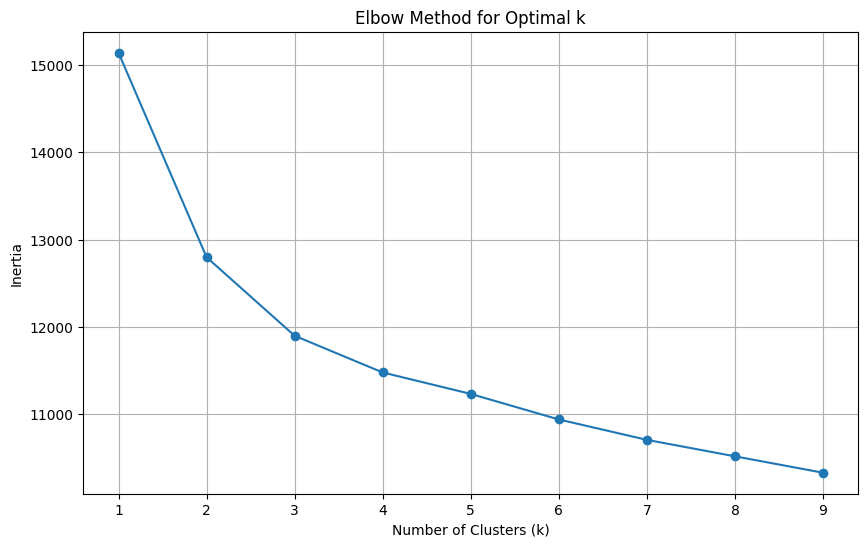

In [49]:
X = brand_features.copy()
X_scaled = StandardScaler().fit_transform(X)

# ELBOW METHOD
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [50]:
# K-means clustering ( n_clusters based on elbow method)
n_clusters = 3 
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
brand_features['cluster'] = kmeans.fit_predict(X_scaled)
brand_features.to_excel(os.path.join(output_dir, 'brand_clusters.xlsx'))

C:\Users\sandr\AppData\Local\Temp\ipykernel_33816\2608792520.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  brand_features['cluster'] = kmeans.fit_predict(X_scaled)


In [51]:
# CLUSTERS
cluster_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
cluster_sizes = brand_features['cluster'].value_counts().sort_index()
print("\nCluster sizes:")
print(cluster_sizes)

print("\nCluster centroids:")
print(cluster_centroids)


Cluster sizes:
cluster
0    37
1    48
2    62
Name: count, dtype: int64

Cluster centroids:
   avg_price  num_products       oil   natural  hyaluronic acid  hydrating  \
0  -0.048374     -0.343250  0.356284  0.455417         0.114956   0.442024   
1  -0.141606      1.102613  0.373333  0.579969         0.752057   0.499942   
2   0.138499     -0.648793 -0.501653 -0.720789        -0.650840  -0.650840   

       balm  cruelty-free     cream     vegan  ...     study      fine  \
0  0.196281      0.453139  0.195996  0.412218  ... -0.284398 -0.284398   
1  0.567589     -0.896239  0.881823 -0.493209  ... -0.284398 -0.284398   
2 -0.556559      0.423441 -0.799667  0.135838  ...  0.389901  0.389901   

   alcohol-free      aloe      long  customizable    tested     aging  \
0     -0.162833  0.588536 -0.270172      0.308293 -0.029909  0.195559   
1      0.474489 -0.270172 -0.270172     -0.168478 -0.255377 -0.255377   
2     -0.270172 -0.142058  0.370397     -0.053547  0.215560  0.081007   

   

In [52]:
# PCA to visualize clusters in 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
for i in range(n_clusters):
    plt.scatter(
        X_pca[brand_features['cluster'] == i, 0],
        X_pca[brand_features['cluster'] == i, 1],
        label=f'Cluster {i}',
        alpha=0.7,
        s=100
    )
for i, brand in enumerate(brand_features.index):
    plt.annotate(
        brand,
        (X_pca[i, 0], X_pca[i, 1]),
        fontsize=9,
        alpha=0.8
    )

plt.title('PCA Cluster Visualization', fontsize=15)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(output_dir, 'cluster_pca_visualization.png'))
plt.close()

In [53]:
# Rradar charts for each cluster like the third image
def radar_chart(cluster_id):
    numeric_features = []
    for term in top_terms:
        if pd.api.types.is_numeric_dtype(brand_features[term]):
            numeric_features.append(term)

    feature_importance = {}
    for feature in numeric_features:
        # Mean value for this feature across all clusters
        all_clusters_mean = []
        for i in range(n_clusters):
            cluster_mean = brand_features[brand_features['cluster'] == i][feature].mean()
            all_clusters_mean.append(cluster_mean)
        
        # If this feature is most prominent in this cluster, it's distinctive
        if np.argmax(all_clusters_mean) == cluster_id:
            feature_importance[feature] = all_clusters_mean[cluster_id]
    
    # Sort features by importance and take top 8
    radar_features = sorted(feature_importance.keys(), 
                           key=lambda x: feature_importance[x], 
                           reverse=True)[:8]
    if len(radar_features) < 5:
        radar_features = numeric_features[:8]
    cluster_brands = brand_features[brand_features['cluster'] == cluster_id].index
    
    values = []
    for feature in radar_features:
        values.append(float(brand_features.loc[cluster_brands, feature].mean()))
    
    # Normalize values between 0 and 1 for radar chart
    min_val = min(values)
    max_val = max(values)
    if max_val > min_val:
        normalized_values = [(val - min_val) / (max_val - min_val) for val in values]
    else:
        normalized_values = [0.5 for _ in values]
    
    N = len(radar_features)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    normalized_values.append(normalized_values[0])
    angles.append(angles[0])
    
    # PLOT:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, normalized_values, 'o-', linewidth=2, color='blue')
    ax.fill(angles, normalized_values, color='blue', alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_features, size=12)

    plt.title(f"Cluster {cluster_id}: Principales Características", size=15, y=1.1)
    ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'cluster_{cluster_id}_radar.png'))
    plt.close()
    
    return fig

for i in range(n_clusters):
    radar_chart(i)


In [54]:
# Heatmaps of feature importance for each cluster
numeric_terms = []
for term in top_terms:
    try:
        brand_features[term] = pd.to_numeric(brand_features[term], errors='coerce')
        numeric_terms.append(term)
    except:
        print(f"Skipping non-numeric term: {term}")
plt.figure(figsize=(15, 10))
cluster_feature_importance = pd.DataFrame(index=range(n_clusters), columns=numeric_terms)

for i in range(n_clusters):
    cluster_brands = brand_features[brand_features['cluster'] == i].index
    for term in numeric_terms:
        cluster_feature_importance.loc[i, term] = brand_features.loc[cluster_brands, term].astype(float).mean()
cluster_feature_importance = cluster_feature_importance.astype(float)

for col in cluster_feature_importance.columns:
    min_val = cluster_feature_importance[col].min()
    max_val = cluster_feature_importance[col].max()
    if max_val > min_val:  # Avoid division by zero
        cluster_feature_importance[col] = (cluster_feature_importance[col] - min_val) / (max_val - min_val)
    else:
        cluster_feature_importance[col] = 0.5  # Default value if all values are the same

try:
    sns.heatmap(cluster_feature_importance, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title('Feature Importance by Cluster', fontsize=15)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'cluster_feature_heatmap.png'))
except Exception as e:
    print(f"Error creating heatmap: {str(e)}")
    plt.figure(figsize=(15, 10))
    plt.imshow(cluster_feature_importance.values, cmap='YlGnBu', aspect='auto')
    plt.yticks(range(len(cluster_feature_importance.index)), cluster_feature_importance.index)
    plt.xticks(range(len(cluster_feature_importance.columns)), cluster_feature_importance.columns, rotation=90)
    plt.colorbar()
    plt.title('Feature Importance by Cluster (Alternative Visualization)', fontsize=15)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'cluster_feature_heatmap_alt.png'))
plt.close()

In [55]:
all_attributes = []
for attr in detection_df['detected_attributes'].dropna():
    if isinstance(attr, str):
        attributes = attr.lower().split(', ')
        all_attributes.extend([a.strip() for a in attributes if a.strip()])

attribute_counts = Counter(all_attributes)
top_attributes = [attr for attr, count in attribute_counts.most_common(30) if attr != '']

# Attribute matrix for each brand
brand_attributes = pd.DataFrame(index=brand_features.index, columns=top_attributes).fillna(0)

for _, row in detection_df.dropna(subset=['brand_detected', 'detected_attributes']).iterrows():
    brand = row['brand_detected']
    if brand in brand_attributes.index and isinstance(row['detected_attributes'], str):
        attrs = row['detected_attributes'].lower().split(', ')
        for attr in attrs:
            attr = attr.strip()
            if attr in top_attributes:
                brand_attributes.loc[brand, attr] += 1

# Normalize by number of mentions
for brand in brand_attributes.index:
    mentions = detection_df[detection_df['brand_detected'] == brand].shape[0]
    if mentions > 0:
        brand_attributes.loc[brand] = brand_attributes.loc[brand] / mentions

brand_attributes['cluster'] = brand_features['cluster']
plt.figure(figsize=(15, 8))

string_attributes = []
for attr in top_attributes:
    string_attributes.append(str(attr))

cluster_attr_importance = pd.DataFrame(index=range(n_clusters), columns=string_attributes)

for i in range(n_clusters):
    cluster_brands = brand_attributes[brand_attributes['cluster'] == i].index
    for attr in string_attributes:
        if attr in brand_attributes.columns:
            # Force numeric conversion
            values = pd.to_numeric(brand_attributes.loc[cluster_brands, attr], errors='coerce')
            cluster_attr_importance.loc[i, attr] = values.mean()
        else:
            cluster_attr_importance.loc[i, attr] = 0.0

cluster_attr_importance = cluster_attr_importance.fillna(0)
cluster_attr_importance = cluster_attr_importance.astype(float)

for col in cluster_attr_importance.columns:
    min_val = cluster_attr_importance[col].min()
    max_val = cluster_attr_importance[col].max()
    if max_val > min_val:  # Avoid division by zero
        cluster_attr_importance[col] = (cluster_attr_importance[col] - min_val) / (max_val - min_val)
    else:
        cluster_attr_importance[col] = 0.5  # Default value if all values are the same
try:
    sns.heatmap(cluster_attr_importance, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title('Attribute Association by Cluster', fontsize=15)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'cluster_attribute_heatmap.png'))
except Exception as e:
    print(f"Error creating attribute heatmap: {str(e)}")
    # Alternative visualization
    plt.figure(figsize=(15, 8))
    plt.imshow(cluster_attr_importance.values, cmap='YlGnBu', aspect='auto')
    plt.yticks(range(len(cluster_attr_importance.index)), cluster_attr_importance.index)
    plt.xticks(range(len(cluster_attr_importance.columns)), cluster_attr_importance.columns, rotation=90)
    plt.colorbar()
    plt.title('Attribute Association by Cluster (Alternative)', fontsize=15)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'cluster_attribute_heatmap_alt.png'))

plt.close()


C:\Users\sandr\AppData\Local\Temp\ipykernel_33816\2597444900.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  brand_attributes = pd.DataFrame(index=brand_features.index, columns=top_attributes).fillna(0)
C:\Users\sandr\AppData\Local\Temp\ipykernel_33816\2597444900.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3076923076923077' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  brand_attributes.loc[brand] = brand_attributes.loc[brand] / mentions
C:\Users\sandr\AppData\Local\Temp\ipykernel_33816\2597444900.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '

In [56]:
# Summary description for each cluster
cluster_summary = {}

for i in range(n_clusters):
    cluster_brands = brand_features[brand_features['cluster'] == i].index.tolist()
    
    avg_price = brand_features[brand_features['cluster'] == i]['avg_price'].mean()
    avg_sentiment = brand_features[brand_features['cluster'] == i]['avg_sentiment'].mean()
    
    # Top features:
    try:
        top_features = cluster_feature_importance.loc[i].sort_values(ascending=False).head(5)
        cluster_terms = top_features.index.tolist()
    except Exception as e:
        cluster_terms = []
        print(f"Warning: Could not extract top terms for cluster {i}: {str(e)}")
    try:
        top_attrs = cluster_attr_importance.loc[i].sort_values(ascending=False).head(5)
        cluster_attrs = top_attrs.index.tolist()
    except Exception as e:
        cluster_attrs = []
        print(f"Warning: Could not extract top attributes for cluster {i}: {str(e)}")
    summary = {
        "brands": cluster_brands,
        "count": len(cluster_brands),
        "avg_price": avg_price,
        "avg_sentiment": avg_sentiment,
        "top_terms": cluster_terms,
        "top_attributes": cluster_attrs
    }
    
    cluster_summary[f"Cluster_{i}"] = summary

# Save:
cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')
cluster_summary_df.to_excel(os.path.join(output_dir, 'cluster_summary.xlsx'))

print("Analysis complete. Results saved to:", output_dir)

Analysis complete. Results saved to: C:\Users\sandr\Documents\scrp_tiktok_tfg\analysis\Kmeans\Kmeans_results
